# **Diplomado IA: Inteligencia Artificial II - Parte 2**. <br> Práctico 2: Meta Aprendizaje
---
---

**Profesores:**
- Julio Hurtado
- Pablo Messina

**Ayudante:**
- Por confirmar
---
---

Importante: este práctico es **INDIVIDUAL**



# Introducción

Este laboratorio está basado fuertemente en [learn2learn](http://learn2learn.net/examples.vision/), una librería open-source para investigación en meta-learning.

En particular, veremos el uso dos métodos concretos:

1) Model-Agnostic Meta-Learning (MAML): https://arxiv.org/abs/1703.03400

2) Prototypical Networks for Few-shot Learning: https://arxiv.org/abs/1703.05175
 
Los datasets que usaremos son Omniglot y Mini-ImageNet, y los códigos consultados para la confección de este laboratorio son los siguientes:

- https://github.com/learnables/learn2learn/blob/master/examples/vision/maml_omniglot.py
- https://github.com/learnables/learn2learn/blob/master/examples/vision/maml_miniimagenet.py
- https://github.com/learnables/learn2learn/blob/master/examples/vision/protonet_miniimagenet.py


# Instalando e importando librerías a usar

In [ ]:
!pip install learn2learn

In [ ]:
import random
import numpy as np
import learn2learn as l2l
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, optim

from IPython.display import clear_output

Usamos cuda

In [ ]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# Cargamos datasets: Omniglot y Mini-ImageNet

Funciones para visualizar tareas de ambos datasets

In [ ]:
def visualize_task_omniglot(batch, shot, ways):
  data = batch[0]
  adaptation_indices = np.zeros(data.size(0), dtype=bool)
  adaptation_indices[np.arange(shot*ways) * 2] = True
  evaluation_indices = torch.from_numpy(~adaptation_indices)
  adaptation_indices = torch.from_numpy(adaptation_indices)
  adaptation_data = data[adaptation_indices]
  evaluation_data = data[evaluation_indices]
  
  print('Adaptation data:')
  n = len(adaptation_data)
  f, axarr = plt.subplots(1,n, figsize=(10,10))
  for i in range(n):
    axarr[i].imshow(adaptation_data[i,0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr)
  plt.show()
  
  print('Evaluation data:')
  n = len(evaluation_data)
  f, axarr = plt.subplots(1,n, figsize=(10,10))
  for i in range(n):
    axarr[i].imshow(evaluation_data[i,0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr)
  plt.show()

def visualize_task_miniimagenet(batch, shots, ways):
  data = batch[0]
  adaptation_indices = np.zeros(data.size(0), dtype=bool)
  adaptation_indices[np.arange(shots*ways) * 2] = True
  evaluation_indices = torch.from_numpy(~adaptation_indices)
  adaptation_indices = torch.from_numpy(adaptation_indices)
  adaptation_data = data[adaptation_indices]
  evaluation_data = data[evaluation_indices]
  
  print('Adaptation data:')
  n = len(adaptation_data)
  f, axarr = plt.subplots(1,n, figsize=(15,15))
  for i in range(n):
    axarr[i].imshow(adaptation_data[i].permute(1,2,0) / 255.)
  np.vectorize(lambda ax:ax.axis('off'))(axarr)
  plt.show()
  
  print('Evaluation data:')
  n = len(evaluation_data)
  f, axarr = plt.subplots(1,n, figsize=(15,15))
  for i in range(n):
    axarr[i].imshow(evaluation_data[i].permute(1,2,0) / 255.)
  np.vectorize(lambda ax:ax.axis('off'))(axarr)
  plt.show()

Definimos WAYS y SHOTS que usaremos

In [ ]:
WAYS = 5
SHOTS = 1

## Cargamos e inspeccionamos Omniglot

In [ ]:
tasksets_omniglot = l2l.vision.benchmarks.get_tasksets('omniglot',
                                                       train_ways=WAYS,
                                                       train_samples=2*SHOTS,
                                                       test_ways=WAYS,
                                                       test_samples=2*SHOTS,
                                                       num_tasks=20000,
                                                       root='~/data',
)

Extracting /root/data/omniglot-py/images_background.zip to /root/data/omniglot-py



Extracting /root/data/omniglot-py/images_evaluation.zip to /root/data/omniglot-py



Adaptation data:


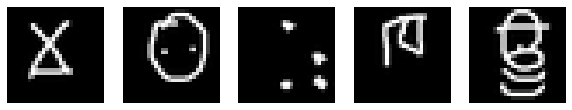

Evaluation data:


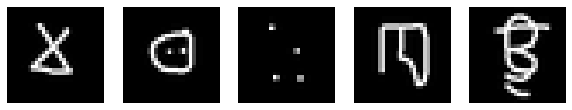

In [ ]:
visualize_task_omniglot(tasksets_omniglot.train.sample(), SHOTS, WAYS)

Adaptation data:


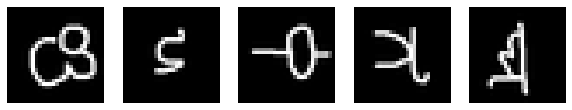

Evaluation data:


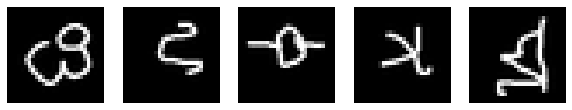

In [ ]:
visualize_task_omniglot(tasksets_omniglot.validation.sample(), SHOTS, WAYS)

Adaptation data:


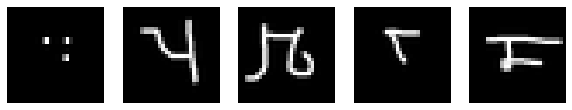

Evaluation data:


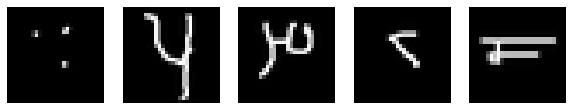

In [ ]:
visualize_task_omniglot(tasksets_omniglot.test.sample(), SHOTS, WAYS)

## Cargamos e inspeccionamos Mini-ImageNet

In [ ]:
tasksets_miniimagenet = l2l.vision.benchmarks.get_tasksets('mini-imagenet',
                                                           train_ways=WAYS,
                                                           train_samples=2*SHOTS,
                                                           test_ways=WAYS,
                                                           test_samples=2*SHOTS,
                                                           num_tasks=20000,
                                                           root='~/data',
)

Adaptation data:


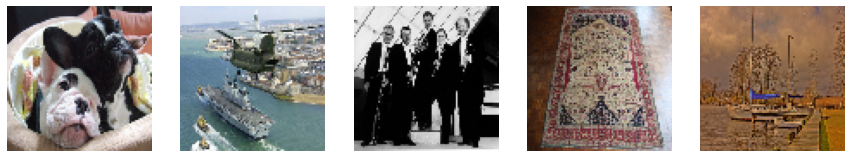

Evaluation data:


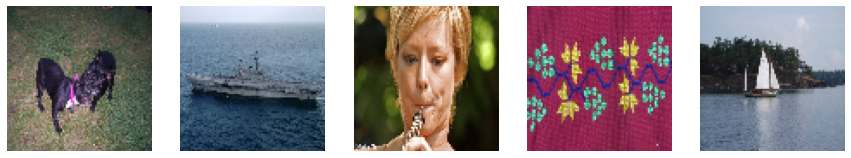

In [ ]:
visualize_task_miniimagenet(tasksets_miniimagenet.train.sample(), SHOTS, WAYS)

Adaptation data:


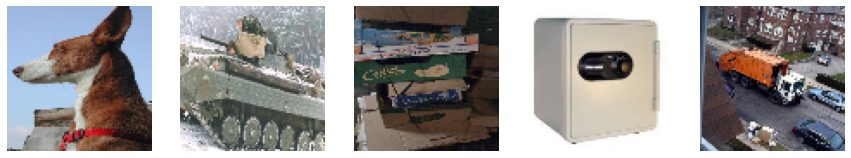

Evaluation data:


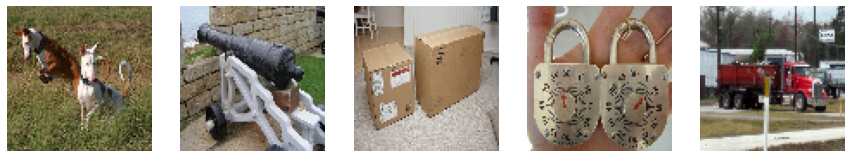

In [ ]:
visualize_task_miniimagenet(tasksets_miniimagenet.validation.sample(), SHOTS, WAYS)

Adaptation data:


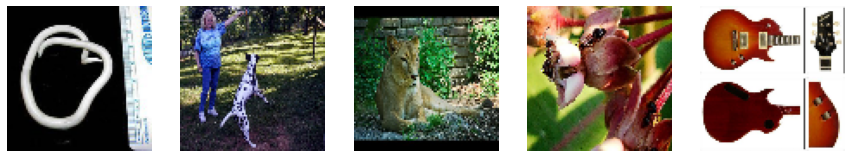

Evaluation data:


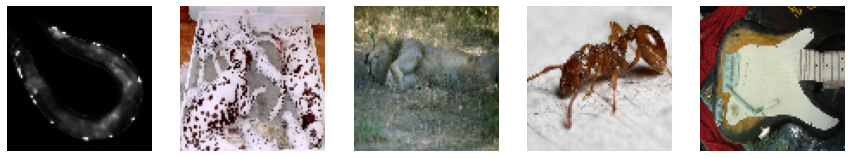

In [ ]:
visualize_task_miniimagenet(tasksets_miniimagenet.test.sample(), SHOTS, WAYS)

# Algunas funciones de utilidad

In [ ]:
# Para graficar funciones de error y accuracy por epoch
def plot_train_valid_curves(train_error, train_acc, valid_error, valid_acc, figsize=(10, 6)):    
    plt.figure(figsize=figsize)    
    epochs = list(range(1, len(train_error)+1))

    plt.subplot(121)
    plt.title('Error per epoch')
    plt.plot(epochs, train_error, label='train_error')
    plt.plot(epochs, valid_error, label='valid_error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Accuracy per epoch')
    plt.plot(epochs, train_acc, label='train_acc')
    plt.plot(epochs, valid_acc, label='valid_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Para calcular accuracy
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

# Model-Agnostic Meta-Learning (MAML)

In [ ]:
def fast_adapt_MAML(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        train_error /= len(adaptation_data)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_error /= len(evaluation_data)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy

def run_MAML(
        tasksets,
        model,
        device,
        ways=5,
        shots=1,
        meta_lr=0.003,
        fast_lr=0.5,
        meta_batch_size=32,
        adaptation_steps=1,
        num_iterations=100,
        cuda=True,
        seed=42,
):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)
    
    # MAML
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
    opt = optim.Adam(maml.parameters(), meta_lr)
    loss = nn.CrossEntropyLoss(reduction='mean')

    train_error = []
    train_acc = []
    valid_error = []
    valid_acc = []

    for iteration in range(num_iterations):
        opt.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0

        for task in range(meta_batch_size):
            # Compute meta-training loss
            learner = maml.clone()
            batch = tasksets.train.sample()
            evaluation_error, evaluation_accuracy = fast_adapt_MAML(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            learner = maml.clone()
            batch = tasksets.validation.sample()
            evaluation_error, evaluation_accuracy = fast_adapt_MAML(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            meta_valid_error += evaluation_error.item()
            meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        clear_output(True)
        print('Iteration', iteration)
        print('Meta Train Error', meta_train_error / meta_batch_size)
        print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
        print('Meta Valid Error', meta_valid_error / meta_batch_size)
        print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)
        train_error.append(meta_train_error / meta_batch_size)
        train_acc.append(meta_train_accuracy / meta_batch_size)
        valid_error.append(meta_valid_error / meta_batch_size)
        valid_acc.append(meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt.step()

    plot_train_valid_curves(train_error, train_acc, valid_error, valid_acc)

    meta_test_error = 0.0
    meta_test_accuracy = 0.0
    for task in range(2000):
        # Compute meta-testing loss
        learner = maml.clone()
        batch = tasksets.test.sample()
        evaluation_error, evaluation_accuracy = fast_adapt_MAML(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_test_error += evaluation_error.item()
        meta_test_accuracy += evaluation_accuracy.item()
    print('Meta Test Error', meta_test_error / 2000)
    print('Meta Test Accuracy', meta_test_accuracy / 2000)

## MAML sobre Omniglot

Iteration 59
Meta Train Error 0.19798199110664427
Meta Train Accuracy 0.6500000134110451
Meta Valid Error 0.1875610725255683
Meta Valid Accuracy 0.6625000108033419


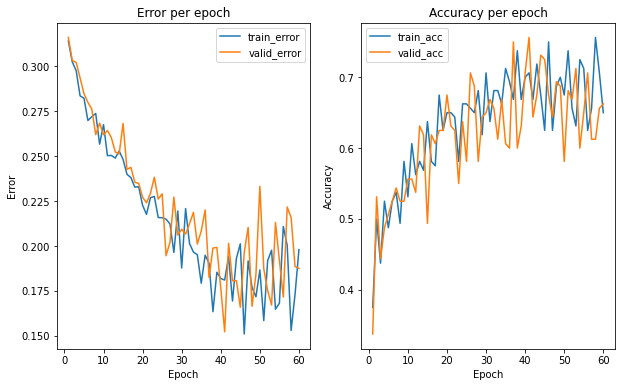

Meta Test Error 0.1904410150712356
Meta Test Accuracy 0.6653000113293529


In [ ]:
model = l2l.vision.models.OmniglotFC(28 ** 2, WAYS)
model.to(device)
run_MAML(tasksets_omniglot, model, device, ways=WAYS, shots=SHOTS, num_iterations=60)

### Actividad 1

La función run_MAML() tiene algunos argumentos con los que se puede jugar, tales como el adaptation_steps, el learning rate, o incluso el modelo que usamos. Modifique los argumentos que estime conveniente con el fin de mejorar los resultados obtenidos. 

Si desea cambiar el modelo, puede definir su propio modelo o bien usar alguno de los modelos disponibles en l2l.vision.models (aquí la documentación: http://learn2learn.net/docs/learn2learn.vision/#learn2learnvisionmodels)

In [ ]:
# su código acá, puede agregar más celdas si lo desea

Comente sus resultados acá (**doble click para editar**)

### Actividad 2

Usando el mejor modelo e hiperparámetros que logró encontar en la Actividad 1:
 
* ¿cómo varían los resultados si ahora modifica el hiperparámetro WAYS?

* ¿cómo varían los resultados si modifica el hiperparámetro SHOTS?

In [ ]:
# su código acá, puede agregar más celdas si lo desea

# Abajo un ejemplo ilustrativo de cómo se pueden modificar SHOTS y WAYS
# notar que debemos redefinir el dataset para ser consistentes con los WAYS y SHOTS

# WAYS = 2
# SHOTS = 1
# tasksets_omniglot_aux = l2l.vision.benchmarks.get_tasksets('omniglot',
#                                                        train_ways=WAYS,
#                                                        train_samples=2*SHOTS,
#                                                        test_ways=WAYS,
#                                                        test_samples=2*SHOTS,
#                                                        num_tasks=20000,
#                                                        root='~/data',
# )
# model = l2l.vision.models.OmniglotFC(28 ** 2, WAYS)
# model.to(device)
# run_MAML(tasksets_omniglot_aux, model, device, ways=WAYS, shots=SHOTS, num_iterations=60, adaptation_steps=2)

Comente sus resultados acá (**doble click para editar**)

## MAML sobre Mini-ImageNet

In [ ]:
WAYS = 5
SHOTS = 1

Iteration 59
Meta Train Error 0.3117215447127819
Meta Train Accuracy 0.3062500059604645
Meta Valid Error 0.3194532888010144
Meta Valid Accuracy 0.3000000058673322


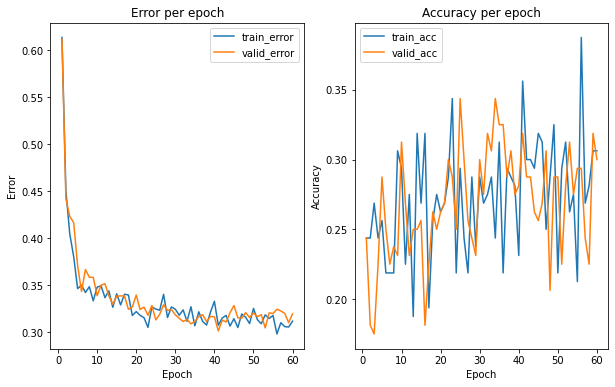

Meta Test Error 0.31507301207631827
Meta Test Accuracy 0.2874000059142709


In [ ]:
model = l2l.vision.models.MiniImagenetCNN(WAYS)
model.to(device)
run_MAML(tasksets_miniimagenet, model, device, ways=WAYS, shots=SHOTS, num_iterations=60)

### Actividad 3

Vemos que 5-way, 1-shot classification en mini-imagenet es bastante más complicado que en omniglot, un resultado esperable ya que las imágenes en mini-imagenet son más complicadas. ¿Mejorarán los resultados si ...

1. ... aumentamos el hiperparámetro SHOTS?
2. ... disminuímos el hiperparámetro WAYS?
3. ... tratamos de probar mejores valores para los argumentos de la función run_MAML (learning rate, iteraciones, la CNN usada, etc.)?




In [ ]:
# su código acá, puede agregar más celdas si lo desea

Comente sus resultados acá (**doble click para editar**)

# Prototypical Networks for Few-shot Learning

In [ ]:
def pairwise_distances_logits(a, b):
    n = a.shape[0]
    m = b.shape[0]
    logits = -((a.unsqueeze(1).expand(n, m, -1) -
                b.unsqueeze(0).expand(n, m, -1))**2).sum(dim=2)
    return logits

def fast_adapt_protonet(model, batch, way, shot, metric=None, device=None):
    if metric is None:
        metric = pairwise_distances_logits
    if device is None:
        device = model.device()
    data, labels = batch
    data = data.to(device)
    labels = labels.to(device)

    # Sort data samples by labels
    sort = torch.sort(labels)
    data = data.squeeze(0)[sort.indices].squeeze(0)
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    # Compute support and query embeddings
    embeddings = model(data)

    support_indices = np.zeros(data.size(0), dtype=bool)
    support_indices[np.arange(shot*way) * 2] = True
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    support = embeddings[support_indices]
    support = support.reshape(way, shot, -1).mean(dim=1)
    query = embeddings[query_indices]
    labels = labels[query_indices].long()

    logits = pairwise_distances_logits(query, support)
    loss = F.cross_entropy(logits, labels)
    acc = accuracy(logits, labels)
    return loss, acc

def run_Protonet(tasksets,
                 model,
                 device,
                 max_epoch=250,
                 shot=1,
                 way=5):
    
    if torch.cuda.device_count():
        torch.cuda.manual_seed(43)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=20, gamma=0.5)
    
    train_error = []
    train_acc = []
    valid_error = []
    valid_acc = []

    for epoch in range(1, max_epoch + 1):
        model.train()

        loss_ctr = 0
        n_loss = 0
        n_acc = 0

        for i in range(200):
            batch = tasksets.train.sample()
            loss, acc = fast_adapt_protonet(model,
                                   batch,
                                   way,
                                   shot,
                                   metric=pairwise_distances_logits,
                                   device=device)

            loss_ctr += 1
            n_loss += loss.item()
            n_acc += acc.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lr_scheduler.step()

        meta_train_error = n_loss/loss_ctr
        meta_train_acc = n_acc/loss_ctr

        model.eval()

        loss_ctr = 0
        n_loss = 0
        n_acc = 0
        for i in range(200):
            batch = tasksets.validation.sample()
            loss, acc = fast_adapt_protonet(model,
                                   batch,
                                   way,
                                   shot,
                                   metric=pairwise_distances_logits,
                                   device=device)

            loss_ctr += 1
            n_loss += loss.item()
            n_acc += acc.item()

        meta_valid_error = n_loss/loss_ctr
        meta_valid_acc = n_acc/loss_ctr
        
        clear_output(True)
        print('Epoch', epoch)
        print('Meta Train Error', meta_train_error)
        print('Meta Train Accuracy', meta_train_acc)
        print('Meta Valid Error', meta_valid_error)
        print('Meta Valid Accuracy', meta_valid_acc)
        train_error.append(meta_train_error)
        train_acc.append(meta_train_acc)
        valid_error.append(meta_valid_error)
        valid_acc.append(meta_valid_acc)

    plot_train_valid_curves(train_error, train_acc, valid_error, valid_acc)
    
    loss_ctr = 0
    n_acc = 0

    for i in range(2000):
        batch = tasksets.test.sample()
        loss, acc = fast_adapt_protonet(model,
                               batch,
                               way,
                               shot,
                               metric=pairwise_distances_logits,
                               device=device)
        loss_ctr += 1
        n_acc += acc.item()
    
    print('Meta Test Error', n_loss/loss_ctr)
    print('Meta Test Accuracy', n_acc/loss_ctr)

## Prototypical Networks sobre Omniglot

Epoch 40
Meta Train Error 0.9001762776076794
Meta Train Accuracy 0.6380000121891498
Meta Valid Error 0.8936104646325111
Meta Valid Accuracy 0.6390000131726264


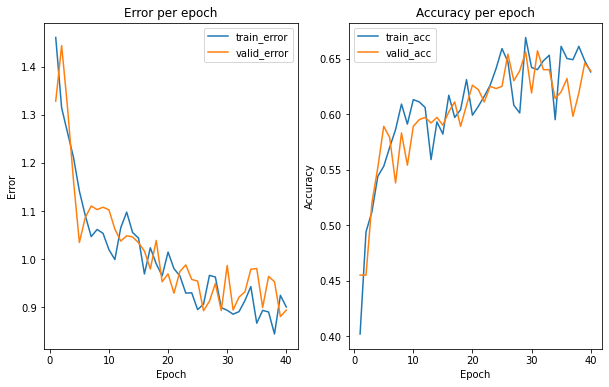

Meta Test Error 0.08936104646325112
Meta Test Accuracy 0.6298000126555562


In [ ]:
model = l2l.vision.models.OmniglotFC(28 ** 2, 50)
model.to(device)
run_Protonet(tasksets_omniglot, model, device, max_epoch=40)

### Actividad 4

¿Mejorarán los resultados de Prototype Networts en omniglot si se reemplaza `model = l2l.vision.models.OmniglotFC(28 ** 2, 50)` con algún otro modelo o variante más sofisticada?

Puede definir su propio modelo o buscar algún modelo en l2l.vision.models (aquí hay documentación: http://learn2learn.net/docs/learn2learn.vision/#learn2learnvisionmodels)

In [ ]:
# su código acá, puede agregar más celdas si lo desea

Comente sus resultados acá (**doble click para editar**)

### Actividad 5

Usando el mejor modelo que logró encontar en la Actividad 4:
 
* ¿cómo varían los resultados si modifica el hiperparámetro WAYS?

* ¿cómo varían los resultados si modifica el hiperparámetro SHOTS?

In [ ]:
# su código acá, puede agregar más celdas si lo desea

Comente sus resultados acá (**doble click para editar**)

## Prototypical Networks sobre Mini-ImageNet

Epoch 40
Meta Train Error 1.4301154723763465
Meta Train Accuracy 0.38700000904500487
Meta Valid Error 1.5309273931384086
Meta Valid Accuracy 0.3480000075697899


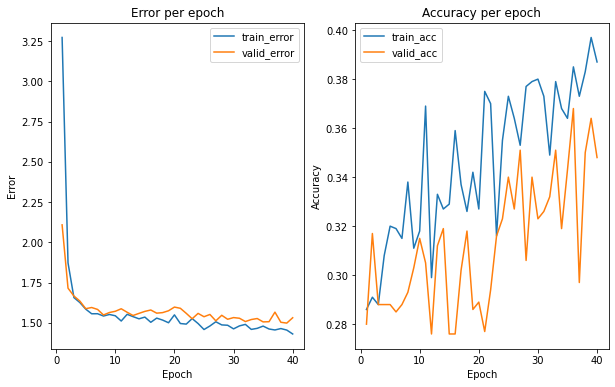

Meta Test Error 0.15309273931384088
Meta Test Accuracy 0.33340000738948583


In [ ]:
model = l2l.vision.models.MiniImagenetCNN(50)
model.to(device)
run_Protonet(tasksets_miniimagenet, model, device, max_epoch=40)

### Actividad 6

Los resultados con Prototype Networks nos confirman nuevamente que mini-imagenet es más complicado que omniglot.

1. ¿Mejorarán los resultados si es que aumentamos el hiperparámetro SHOTS?
2. ¿Mejorarán los resultados si es que disminuímos el hiperparámetro WAYS?
3. ¿Mejorarán los resultados con una versión distinta de CNN (más capas, otra arquitectura, etc.)?




In [ ]:
# su código acá, puede agregar más celdas si lo desea

Comente sus resultados acá (**doble click para editar**)

### Actividad 7
Preguntas teóricas

1) Recordemos que MAML es un método de meta-aprendizaje basado en optimización, que a simple vista se ve muy parecido al fine-tuning tradicional. Sin embargo, hay una diferencia clave en cómo se realiza la optimización durante el meta-entrenamiento que los hace distintos. ¿Cuál es esa diferencia? ¿Qué beneficios le trae dicha diferencia a MAML por sobre el fine-tuning tradicional y por qué?

**Respuesta**: (doble click para editar)

2) En la clase vimos 3 metódos de meta-aprendizaje no-parametrizados: Redes Siamesas, Matching Networks y Prototype Networks. El segundo método propone mejoras sobre el primero y el tercero mejoras sobre el segundo.

A grandes rasgos, ¿en qué consiste cada método? ¿Cuáles son las mejoras que los últimos dos métodos proponen?

**Respuesta**: (doble click para editar)